## Importing Necessary Libraries and Functions

The first thing we need to do is import the necessary functions and libraries that we will be working with throughout the topic. We should also go ahead and upload all the of the necessary data sets here instead of loading them as we go. We will be using energy production data from PJM Interconnection. They are a regional transmission organization that coordinates the movement of wholesale electricity in parts of the United States. Specifically, we will be focused on a region of Pennsylvania. We will also be using temperature data collected from the National Oceanic and Atmospheric Assocation (NOAA).

In [ ]:
!conda update -n base -c defaults conda

!conda install pandas -y
!conda install numpy -y
!conda install matplotlib -y
!conda install statsmodels -y
!pip install scipy 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

This milestone builds off the previous ones so we should complete the following steps to the first milestone again to have our data prepped and ready to go. We should also rebuild our last model from milestone 3 since that is our foundational model!

## Preparing the Energy and Temperature Data

First we need to load our weather and energy data sets for cleaning. Let's use the pandas library and the ```read.csv``` function to do this.

In [2]:
# Loading the Needed Data Sets 
weather = pd.read_csv('.../hr_temp_20170201-20200131_subset.csv')
energy = pd.read_csv('.../hrl_load_metered - 20170201-20200131.csv')


It is always good practice to take a look at the first few observations of the data set to make sure that everything looks like how we expected it to when we read in our CSV file. Let's use the ```head``` function for this.

In [3]:
weather.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01T00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01T01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01T02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01T03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01T04:53:00,FM-15,7,36.0


Perfect! We have temperature as well as time. There are some other pieces of information like the station number, source of the reading and reading type, but we don't need those.

Let's take a look at the first few observations of the energy data as well!

In [4]:
energy.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True


Great! Again, we have the important information of time as well as megawatt (MW) readings per hour. Again, there are some other varibales that we won't end up using in this data set as well.

Let's get rid of the variables we don't need and combine the variables that we do need into one pandas data frame. Dictionaries are an easy way of doing this. Here, we are pulling the MW column from the energy data set as well as the temperature and date columns from the weather data set. These data sets already line up on time which makes this much easier.

In [5]:
d = {'MW': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature'], 'Date': weather['DATE']}

Now let's create our pandas data frame.

In [6]:
df = pd.DataFrame(d)

One of the problems when loading a data set you want to run time series analysis on is the type of object Python sees for the "date" variable. Let's look at the pandas data frame data types for each of our variables.

In [7]:
print(df.dtypes)

MW      float64
Temp    float64
Date     object
dtype: object


Here we can see that the Date variable is a general object and not a "date" according to Python. We can change that with the pandas function ```to_datetime``` as we have below.

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

MW             float64
Temp           float64
Date    datetime64[ns]
dtype: object


Good! Now that we have a ```datetime64``` object in our data set we can easily create other forms of date variables. The hour of day, day of week, month of year, and possibly even the year itself might all impact the energy usage. Let's extract these variables from our date object so that we can use them in our analysis. Pandas has some wonderful functionality to do this with the ```hour```, ```day```, ```dayofweek```, ```month```, and ```year``` functions. Then let's inspect the first few observations to make sure things look correct.

In [9]:
df['hour'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).hour
df['day'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).day
df['weekday'] = df['Date'].dt.dayofweek
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year

df.head()

,MW,Temp,Date,hour,day,weekday,month,year
0,1419.881,37.0,2017-02-01 00:53:00,0,1,2,2,2017
1,1379.505,37.0,2017-02-01 01:53:00,1,1,2,2,2017
2,1366.106,36.0,2017-02-01 02:53:00,2,1,2,2,2017
3,1364.453,36.0,2017-02-01 03:53:00,3,1,2,2,2017
4,1391.265,36.0,2017-02-01 04:53:00,4,1,2,2,2017


Everything looks good in the first few observations above. If you still aren't convinced you could pull different pieces of the data frame to make sure that other observations are structured correctly.

Now we should set this Python date object as the index of our data set. This will make it easier for plotting as well as forecasting later. We can use the ```set_index``` function for this.

In [10]:
df = df.set_index('Date')

Good! Now that we have our data structured as we would like, we can start the cleaning of the data. First, let's check if there are any missing values in the temperature column. The ```is.null``` function will help us here.

In [11]:
sum(df['Temp'].isnull())

37

Looks like there are 37 missing values in our temperature data. We shoudl impute those. However, we don't just want to put the average temperature in these spots as the overall average across three years probably isn't a good guess for any one hour. The temperature of the hours on either side of the missing observation would be more helpful. Let's do a linear interpolation across missing values to help with this. This will essentially draw a straight line between the two known points to fill in the missing values. We can use the ```interpolate(method='linear')``` function for this.

In [12]:
df['Temp'] = df['Temp'].interpolate(method='linear')

Now let's see if we have any more missing temperature values.

In [13]:
sum(df['Temp'].isnull())

0

No more! Time to check if the energy data has any missing values.

In [14]:
sum(df['MW'].isnull())

0

No missing values there either! Perfect.

Now it is time to split the data into two pieces - training and testing. The training data set is the data set we will be building our model on, while the testing data set is what we will be reporting results on since the model wouldn't have seen it ahead of time. Using the date index we can easily do this in our data frame.

In [15]:
#Training and Validation Split #
train = pd.DataFrame(df['2017-01-01':'2019-12-31'])
test = pd.DataFrame(df['2020-01-01':'2020-01-31'])

Now let's look at the first few observations for our training data set.

In [16]:
train.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017


Everything looks good there!

Now let's do the same for our testing data set.

In [17]:
test.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020


Excellent! We now have our data cleaned and split. By combining and cleaning the data sets, we will make the exploration of these data sets as well as the modeling of these data sets much easier for the upcoming sections!

## Building Naive Energy Model

Now that we have recreated the pieces of milestone 1 that clean and split our data we can start the modeling phase of milestone 3.

First, let's review some of the findings we have from the first two milestones:
- Energy usage changes depending on month / season
- Energy usage changes depending on day of week
- Energy usage changes depending on hour of day
- Energy usage changes depending on outside temperature
- The relationship between temperature and energy usage appears quadratic in nature

Looking at this last bullet point, we need to create a quadratic variable on temperature as temperature in the model by itself won't be enough to model energy usage. It is always good practice to standardize (mean of 0 and standard deviation of 1) any variable you are going to raise to a higher power in a regression to help prevent multicollinearity problems. We can standardize the variable *Temp* by using the ```mean``` and ```std``` functions.

In [18]:
train['Temp_Norm'] = (train['Temp']-train['Temp'].mean())/train['Temp'].std()

Now that temperature is standardized (or normalized) we can just multiply it by itself to get our quadratic term.

In [19]:
train['Temp_Norm2'] = train['Temp_Norm']**2

Let's do a brief look at the first few observations in our training data set to make sure that things worked as expected.

In [20]:
train.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2
Date,,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017,-0.871499,0.759511
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017,-0.871499,0.759511
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017,-0.924494,0.854690
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017,-0.924494,0.854690
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017,-0.924494,0.854690


In [21]:
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:37:57   Log-Likelihood:            -1.4774e+05
No. Observations:               25536   AIC:                         2.960e+05
Df Residuals:                   25287   BIC:                         2.980e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

All of those terms appeared significant too! Excellent. Now we have our naive energy model. It takes into account the hour of day, day of week, month of year, and the complicated relationship with temperature. 

Time to see how good our predictions are. One evaluation of model performance is the mean absolute percentage error (MAPE). This evaluates on average how far off are our predictions in terms of percentages. We need to get our predictions from our training data set. The ```fittedvalues``` function will do that for us. Then we can calculate the MAPE ourselves.

In [22]:
train['fitted'] = results.fittedvalues

train['APE'] = abs((train['MW']-train['fitted'])/train['MW'])*100
print("Training Naive Model MAPE is: ", train['APE'].mean())

Training Naive Model MAPE is:  3.5119541032055452


On average, our model incorrectly predicted energy usage by a little over 3.5%! That gives us a good baseline to compare our future models with.



In [23]:
test['Temp_Norm'] = (test['Temp']-test['Temp'].mean())/test['Temp'].std()
test['Temp_Norm2'] = test['Temp_Norm']**2

Let's forecast out our model by scoring the test data set with the linear regression we built. Remember, we don't want to build a model on the test data set, just run the observations through the equation we got from the training model. These are our January 2020 predictions! The ```predict``` function will help us with this. We need to specify which data set we are predicting as you see with the ```predict(test)``` below. Let's look at the first few observations from this prediction!

In [24]:
test['pred'] = results.predict(test)

test.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2,pred
Date,,,,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020,-0.435454,0.189621,1301.224887
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020,-0.627840,0.394184,1296.150033
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020,-0.531647,0.282649,1280.104337
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020,-0.531647,0.282649,1292.227132
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020,-0.435454,0.189621,1334.757899


Good! Now let's plot our predictions for the test data set against the actual values.

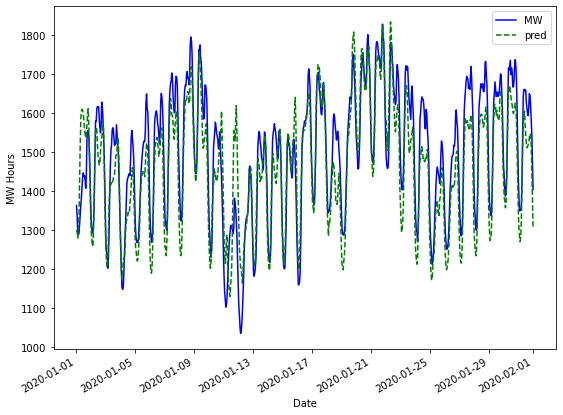

In [25]:
test['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['pred'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

Those look like rather good predictions! Let's see what the MAPE is on these.

In [26]:
test['APE'] = abs((test['MW']-test['pred'])/test['MW'])*100
print("Naive Model MAPE is: ", test['APE'].mean())

Naive Model MAPE is:  4.3947190107463365


Great! Remember, the MAPE is probably going to be higher because our model hasn't seen this data before. This is a great way to truly evaluate how well your model will do when deployed in a real world setting since you won't know energy data before you predict it. Looks like our model is only off by 4.4% on average.

The foundation is laid in this step. Model building can be complicated and sometimes it is hard to know when to stop. The best plan is to build a foundational model that you can try to build upon and/or outperform with later editions of your model. Without a good baseline, you won't know how good your final model is. These seasonal effects of hours of day, days of week, months of year as well as the temperature effects build a great first attempt at forecasting future energy usage.

This is a great initial model if your boss needs a check-in to see your progress. This model gets you a long way there since you have incorporated temperature's complicated relationship. In the next milestones you get to build on this great foundation to really show your boss what you can do!

## Holiday Effects

Now that we have recreated the important pieces of milestones 1 and 3, we can move on to milestone 5's objectives. 

We have had a lot of great models built up until this point. The naive energy model is a great model in itself. The dynamic time series model improved greatly on the naive model by incorporating time series components to our forecasts. However, with multiple iterations of time series models we didn't see much improvement between the time series models. That leads us to think that improvements from this point will come from creative feature engineering as compared to modeling techniques. 

To help this discussion, let's view the forecast from our naive model on a holiday - December 25, 2019. Use can plot both the actual and fitted values on the same plot.

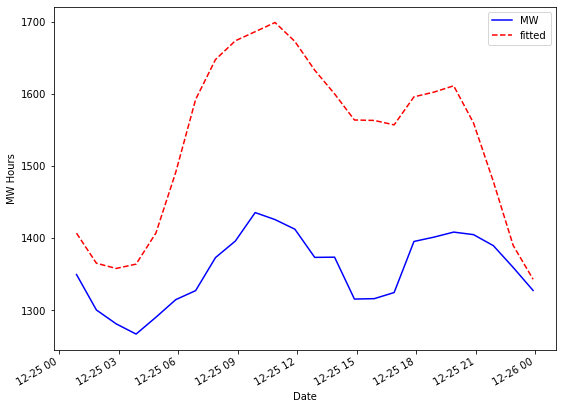

In [27]:
train['2019-12-25':'2019-12-25']['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

train['2019-12-25':'2019-12-25']['fitted'].plot(color = 'red', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

We can see that our model doesn't do too well at being able to predict this holiday. This shouldn't be too surprising! This was a Wednesday, which is typically one of the highest energy usage days of the week. However, most businesses were closed on this day which lead to lower energy usage than any typical Wednesday in the winter. 

The next factors we can include in our model are holiday variables to capture those effects! Government holidays usually close most major businesses and lead to lower energy usage for those days. If we are going to account for holidays, we need to first record which days are holidays in our data set as a separate variable.

Luckily, pandas has a US federal holiday calendar built in that we can use.

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar

It is easier to use this calendar on our original data set when we were creating the day of week, and month of year variables as compared to our indexed one. Let's retrace our steps here by going back and re-uploading our data and building that pandas data frame. Just don't set the index yet!

In [29]:
# Loading the Needed Data Sets 
weather = pd.read_csv('C:/Users/adlabarr/Google Drive/Consulting/Manning Publications/liveProject/Energy Demand Forecasting/Data/hr_temp_20170201-20200131_subset.csv')
energy = pd.read_csv('C:/Users/adlabarr/Google Drive/Consulting/Manning Publications/liveProject/Energy Demand Forecasting/Data/hrl_load_metered - 20170201-20200131.csv')


In [30]:
d = {'MW': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature'], 'Date': weather['DATE']}

In [31]:
df = pd.DataFrame(d)

In [32]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

MW             float64
Temp           float64
Date    datetime64[ns]
dtype: object


In [33]:
df['hour'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).hour
df['day'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).day
df['weekday'] = df['Date'].dt.dayofweek
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year

Excellent! Now let's create a holiday variable. The code below uploads the US federal holiday calendar and creates flags for those days in our data set. The downside of our data set is that we have date with hours, minutes, and seconds. The holiday calendar has all these set to 0. Let's create an index for our holidays that sets these to zero as well and then copy these holidays over into our data frame as a *holiday* variable.

In [34]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())

dt_holiday = [ ]
for idx,row in df.iterrows():
    cur_dt = row[ 'Date' ]
    cur_dt = cur_dt.replace( hour=0, minute=0, second=0 )
    dt_holiday.append( cur_dt in holidays )
    
df[ 'holiday' ] = dt_holiday

Good! Our data has 30 hoidays in it. For 24 hours in each, that would be 720 holiday hours. Let's quickly take a sum of our binary holiday variable to see if we have 720 holidays hours in our data frame.

In [35]:
sum(df['holiday'])

720

Excellent! Now we have a holiday variable and we can recreate the rest of our data frame as in milestone 1.

Now we should set this Python date object as the index of our data set. This will make it easier for plotting as well as forecasting later. We can use the ```set_index``` function for this.

In [36]:
df = df.set_index('Date')

In [38]:
df['Temp'] = df['Temp'].interpolate(method='linear')

Time to create our training and test data sets again.

In [39]:
#Training and Validation Split #
train = pd.DataFrame(df['2017-01-01':'2019-12-31'])
test = pd.DataFrame(df['2020-01-01':'2020-01-31'])

We also need to recreate our naive model so we can properly compare things and have a good training data set since we overwrote it above. The next few chunks of code do just that!

In [40]:
train['Temp_Norm'] = (train['Temp']-train['Temp'].mean())/train['Temp'].std()

In [41]:
train['Temp_Norm2'] = train['Temp_Norm']**2

In [42]:
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:23:29   Log-Likelihood:            -1.4774e+05
No. Observations:               25536   AIC:                         2.960e+05
Df Residuals:                   25287   BIC:                         2.980e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [43]:
train['fitted'] = results.fittedvalues

train['APE'] = abs((train['MW']-train['fitted'])/train['MW'])*100
print("Training Naive Model MAPE is: ", train['APE'].mean())

Training Naive Model MAPE is:  3.5119541032055452


In [44]:
test['Temp_Norm'] = (test['Temp']-test['Temp'].mean())/test['Temp'].std()
test['Temp_Norm2'] = test['Temp_Norm']**2

In [45]:
test['pred'] = results.predict(test)

In [46]:
test['APE'] = abs((test['MW']-test['pred'])/test['MW'])*100
print("Naive Model MAPE is: ", test['APE'].mean())

Naive Model MAPE is:  4.3947190107463365


Great! Now we are ready to incorporate the holiday effects into our model. Let's do this by adding new variables to our naive energy model linear regression. We will incorporate not only a holiday variable, but an interaction of this holiday variable with the day of week variable. This is because we don't expect holidays to impact weekends as much as weekdays.

In [47]:
results_h = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour)+ Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour) + C(holiday)*C(weekday)', 
                              data=train).fit()
print(results_h.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1274.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:25:46   Log-Likelihood:            -1.4726e+05
No. Observations:               25536   AIC:                         2.950e+05
Df Residuals:                   25282   BIC:                         2.971e+05
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Holiday seems to be an important and significant variable in our model! 

Now we can continue as we did before. Let's incorporate the dynamic time series models into our energy model. You are welcome to choose any of the three models we came up with in milestone 4 - the ESM, the ARIMA, the ensemble between the two. The code below will go through and just create the ARIMA model since it had the best training MAPE.

In [48]:
train['fitted_h'] = results_h.fittedvalues
test['pred_h'] = results_h.predict(test)

train['resid_h'] = results_h.resid

In [49]:
mod = SARIMAX(train['resid_h'], order=(2,0,0), seasonal_order=(0,1,1,24))
res = mod.fit()

print(res.summary())

C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                              resid_h   No. Observations:                25536
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -127541.775
Date:                              Fri, 09 Oct 2020   AIC                         255091.551
Time:                                      15:45:13   BIC                         255124.138
Sample:                                           0   HQIC                        255102.088
                                            - 25536                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8081      0.003    266.097      0.000       0.802       0.814
ar.L2          0.07

In [50]:
forecast = pd.DataFrame(res.forecast(744))
forecast.index = test.index.copy()

train['fitted_resid2_h'] = res.predict()
test['pred_resid2_h'] = forecast

train['fitted_ARIMA_h'] = train['fitted_h'] + train['fitted_resid2_h']
test['pred_ARIMA_h'] = test['pred_h'] + test['pred_resid2_h']

train['APE_ARIMA_h'] = abs((train['MW']-train['fitted_ARIMA_h'])/train['MW'])*100
test['APE_ARIMA_h'] = abs((test['MW']-test['pred_ARIMA_h'])/test['MW'])*100

print("Training Naive Holiday + ARIMA Model MAPE is: ", train['APE_ARIMA_h'].mean())
print("Naive Holiday + ARIMA Model MAPE is: ", test['APE_ARIMA_h'].mean())

Training Naive Holiday + ARIMA Model MAPE is:  1.3796697872368366
Naive Holiday + ARIMA Model MAPE is:  5.110289110179473


C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Excellent! Looks like our training MAPE didn't really improve too much, but our test MAPE is lower than the ARIMA dynamic energy model without the holiday effects.

Let's recreate that plot of December 25, 2019 with our new model as well. Now we can see the actual data, the original naive model, and now our final dynamic energy model with holiday effects.

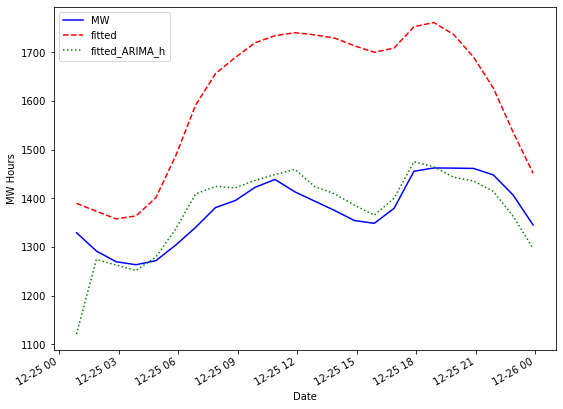

In [52]:
train['2018-12-25':'2018-12-25']['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

train['2018-12-25':'2018-12-25']['fitted'].plot(color = 'red', linestyle = 'dashed', figsize=(9,7))
train['2018-12-25':'2018-12-25']['fitted_ARIMA_h'].plot(color = 'green', linestyle = ':', figsize=(9,7))

plt.legend(loc="best");

plt.show()

That looks so much better as a prediction for the holiday! Nicely done. 

Congratulations on having your final model built! Now its time to produce your forecast of February. First, we will need the data for Febrauary's weather.

In [53]:
weather_feb = pd.read_csv('.../hr_temp_20200201-20200229_subset.csv')

Now we will need to replicate what we did to our test data with this new February data. The next chunk of code will recreate the temperature variables, the time variables, and the holiday variables.

In [54]:
d_feb = {'Temp': weather_feb['HourlyDryBulbTemperature'], 'Date': weather_feb['DATE']}

df_feb = pd.DataFrame(d_feb)

df_feb['Date'] = pd.to_datetime(df_feb['Date'])

df_feb['hour'] = pd.DatetimeIndex(pd.to_datetime(df_feb['Date'])).hour
df_feb['day'] = pd.DatetimeIndex(pd.to_datetime(df_feb['Date'])).day
df_feb['weekday'] = df_feb['Date'].dt.dayofweek
df_feb['month'] = pd.DatetimeIndex(pd.to_datetime(df_feb['Date'])).month
df_feb['year'] = pd.DatetimeIndex(pd.to_datetime(df_feb['Date'])).year

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_feb['Date'].min(), end=df_feb['Date'].max())

dt_holiday = [ ]
for idx,row in df_feb.iterrows():
    cur_dt = row[ 'Date' ]
    cur_dt = cur_dt.replace( hour=0, minute=0, second=0 )
    dt_holiday.append( cur_dt in holidays )
    
df_feb[ 'holiday' ] = dt_holiday

df_feb = df_feb.set_index('Date')

df_feb['Temp_Norm'] = (df_feb['Temp']-train['Temp'].mean())/train['Temp'].std()

df_feb['Temp_Norm2'] = df_feb['Temp_Norm']**2

df_feb.head()

,Temp,hour,day,weekday,month,year,holiday,Temp_Norm,Temp_Norm2
Date,,,,,,,,,
2020-02-01 00:51:00,32,0,1,5,2,2020,False,-1.136476,1.291578
2020-02-01 01:51:00,32,1,1,5,2,2020,False,-1.136476,1.291578
2020-02-01 02:51:00,32,2,1,5,2,2020,False,-1.136476,1.291578
2020-02-01 03:51:00,32,3,1,5,2,2020,False,-1.136476,1.291578
2020-02-01 04:51:00,31,4,1,5,2,2020,False,-1.189471,1.414842


Now we have our February data structured just like our other data sets. Now we need to take our original data and create the temperature quadratic term as well. We have this in each of the training and test, but not in the original whole data set.

In [55]:
df_final = df

df_final['Temp_Norm'] = (df_final['Temp']-train['Temp'].mean())/train['Temp'].std()

df_final['Temp_Norm2'] = df_final['Temp_Norm']**2

Now our data is ready! We have our full data set ready to model. Time to repeat the linear regression with holiday effects, but now on the whole data set.

In [56]:
results_final = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour)+ Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour) + C(holiday)*C(weekday)', 
                              data=df_final).fit()
print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1302.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:55:38   Log-Likelihood:            -1.5141e+05
No. Observations:               26280   AIC:                         3.033e+05
Df Residuals:                   26026   BIC:                         3.054e+05
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Just like before, we need to save the fitted values and get the residuals for our ARIMA model.

In [58]:
df_final['pred_final'] = results_final.fittedvalues
df_final['resid_final'] = results_final.resid

Now we need to score our February data set to get our predictions for February based on the linear regression alone. Luckily the ```predict``` function works great for this. All we need to input is the February weather data we created.

In [59]:
df_feb['pred_final'] = results_final.predict(df_feb)

Now we need the ARIMA model on the residuals. Time to repeat that piece of the code above, but now on the whole data set's residuals instead of just the training. Remember, there are only 696 hours to forecast for February, not 744.

In [60]:
mod = SARIMAX(df_final['resid_final'], order=(2,0,0), seasonal_order=(0,1,1,24))
res = mod.fit()

forecast_ARIMA = pd.DataFrame(res.forecast(696))
forecast_ARIMA.index = df_feb.index.copy()

df_feb['forecast_ARIMA'] = forecast_ARIMA

df_feb['forecast_final'] = df_feb['pred_final'] + df_feb['forecast_ARIMA']

df_feb.head()

C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Temp,hour,day,weekday,month,year,holiday,Temp_Norm,Temp_Norm2,pred_final,forecast_ARIMA,forecast_final
Date,,,,,,,,,,,,
2020-02-01 00:51:00,32,0,1,5,2,2020,False,-1.136476,1.291578,1368.167570,-1.169483,1366.998087
2020-02-01 01:51:00,32,1,1,5,2,2020,False,-1.136476,1.291578,1337.947404,-6.468877,1331.478527
2020-02-01 02:51:00,32,2,1,5,2,2020,False,-1.136476,1.291578,1314.707113,-8.780554,1305.926559
2020-02-01 03:51:00,32,3,1,5,2,2020,False,-1.136476,1.291578,1309.664658,-18.866333,1290.798325
2020-02-01 04:51:00,31,4,1,5,2,2020,False,-1.189471,1.414842,1325.709320,-32.276497,1293.432823


Perfect! Now you have your final model and your final forecast. All of your hard work in terms of exploring and building models on your data have paid off with your final forecast. This is the most important step of all! You must report this final forecast to your superiors at the energy company. No model is useful until some can make decisions on the results from it! One easy way to help with this is to visualize the forecast.

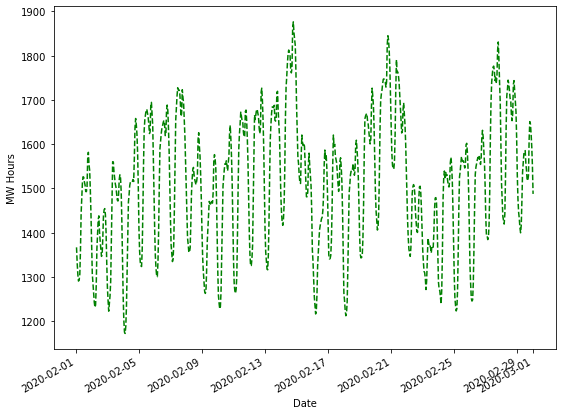

In [61]:
df_feb['forecast_final'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

plt.show()

Congratulations! You have completed your final energy forecast! You have gone through the hard work of squeezing all the available signal out of the energy data to produce results that had a MAPE under 1.4%! That is right on par (or even better) than industry standards. 

Nicely done!